In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from scipy.signal import medfilt
from scipy.stats import norm
from sklearn import metrics
from sklearn.metrics import r2_score
from tabulate import tabulate
from tqdm import tqdm

%matplotlib inline 

In [2]:
with open('config.json') as f:
    config = json.load(f)
s_dim = len(config['spectra features'])
t_dim = len(config['FATS keys'])
s_dim, t_dim

(2, 7)

In [3]:
print('CONFIG')
print(config)

CONFIG
{'spectra features': ['spec2', 'spec5'], 'FATS keys': ['PeriodLS', 'Freq1_harmonics_amplitude_0', 'MedianAbsDev', 'Q31', 'FluxPercentileRatioMid35', 'FluxPercentileRatioMid50', 'Freq1_harmonics_amplitude_1'], 'gmm_components': 20}


In [4]:
classification_path = './classification_entropy.csv'

In [5]:
probs = pd.read_csv(classification_path)
probs.head()

,ts_names,EA_ts,EW_ts,RRab_ts,RRc_ts,RRd_ts,RS CVn_ts,EA_mix,EW_mix,RRab_mix,...,RRd_marg,RS CVn_marg,H_mix_mean,s_uncertainty,pred_marg,pred_marg_prob,H_ts,H_mix,H_diff_approx,ground_diff
0,1132062052528,0.0,0.030,0.005,0.945,0.020,0.0,0.000,0.030,0.000,...,0.0,0.0,0.187479,5.070082,RRc,1.000,0.263388,0.134742,0.075909,0.025
1,1001072050924,0.0,0.950,0.005,0.040,0.005,0.0,0.005,0.965,0.015,...,0.0,0.0,0.164062,5.136999,EW,1.000,0.230467,0.186863,0.066405,0.015
2,1121054053106,0.0,0.005,0.985,0.010,0.000,0.0,0.000,0.000,0.995,...,0.0,0.0,0.220362,5.054955,RRab,1.000,0.087430,0.031479,-0.132932,0.010
3,1126077024700,0.0,0.035,0.025,0.925,0.015,0.0,0.000,0.050,0.005,...,0.0,0.0,0.309486,4.947624,RRc,0.955,0.344666,0.306765,0.035180,0.005
4,1138033064612,0.0,0.040,0.000,0.935,0.025,0.0,0.000,0.080,0.000,...,0.0,0.0,0.169345,5.042658,RRc,0.995,0.283817,0.605429,0.114472,-0.120


In [6]:
c2 = probs['pred_ts']!=probs['target']
c3 = probs['pred_mix']==probs['target']
sum(c2 & c3)

101

### Strategies

In [7]:
def filter_lift(probs, filter_, strategy, sort_by='H_diff_approx'):
    probs = probs.copy()
    probs[strategy] = 0
    
    top = probs[filter_]
    top = top.sort_values(sort_by, ascending=False)
    top_offset = probs.shape[0]-top.shape[0]
    top_index = list(range(top_offset, probs.shape[0]))[::-1]
    top[strategy] = top_index
    print(top.shape)
    
    bottom = probs[~filter_]
    bottom = bottom.sort_values(sort_by, ascending=False)
    bottom_index = list(range(0, top_offset))[::-1]
    bottom[strategy] = bottom_index
    
    probs.loc[top.index, strategy] = top[strategy]
    probs.loc[bottom.index, strategy] = bottom[strategy]
    
    return probs

def add_strategies(probs):
    probs = probs.copy()
    fn = lambda str_: str_.rstrip('_marg')
    probs['pred_marg'] = probs['pred_marg'].apply(fn)

    probs['max'] = probs['H_ts']-probs['H_mix']
    probs['baseline'] = probs['H_ts']
    probs['strategy1'] = probs['H_diff_approx']

    c1 = probs['pred_ts']!=probs['pred_marg']
    print(c1.sum())

    strategy = 'strategy2'
    filter_ = c1
    probs = filter_lift(probs, filter_, strategy)
    
    strategy = 'strategy3'
    filter_ = c1
    probs = filter_lift(probs, filter_, strategy, 'H_ts')
    
    info = {}
    info['max'] = 'Best scenario'
    info['baseline'] = r'$H_{t}$'
    info['strategy1'] = r'$IG(x_{t})$'
    info['strategy2'] = r'$IG(x_{t}) + \Delta \hat{y}(x_t)$'
    info['strategy3'] = r'$H_{t} + \Delta \hat{y}(x_t)$'
    
    return probs, info

In [8]:
probs, strategies_info = add_strategies(probs)

113
(113, 40)
(113, 41)


In [9]:
c1 = probs['pred_ts']!=probs['pred_marg']
c2 = probs['pred_ts']!=probs['target']
c3 = probs['pred_mix']==probs['target']
sum(c1), sum(c1&c2&c3), sum(c2&c3), probs.shape[0], sum(c2)

(113, 46, 101, 2554, 390)

In [10]:
strategies_info

{'max': 'Best scenario',
 'baseline': '$H_{t}$',
 'strategy1': '$IG(x_{t})$',
 'strategy2': '$IG(x_{t}) + \\Delta \\hat{y}(x_t)$',
 'strategy3': '$H_{t} + \\Delta \\hat{y}(x_t)$'}

### Metrics and graphs

In [11]:
np.corrcoef(probs['s_uncertainty'], probs['ground_diff'])

array([[ 1.        , -0.01308498],
       [-0.01308498,  1.        ]])

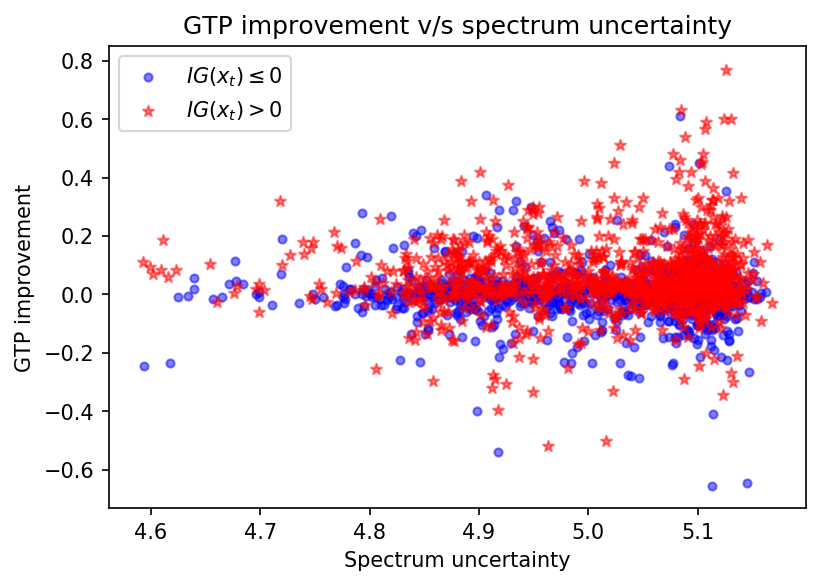

In [12]:
# plt.rcParams.update({'font.size': 15})
plt.rcdefaults()
plt.figure(figsize=(6,4), dpi=150)
c1 = probs['H_diff_approx']>0

aux = probs[~c1]
x_ = aux['s_uncertainty'].values
y_ = aux['ground_diff'].values
plt.scatter(x_,y_, s = 15, c='b', label=r'$IG(x_t) \leq 0$', alpha=0.5)

aux = probs[c1]
x_ = aux['s_uncertainty'].values
y_ = aux['ground_diff'].values
plt.scatter(x_,y_, s = 30, marker='*', c='r', label=r'$IG(x_t) > 0$', alpha=0.5)

plt.legend()
plt.title('GTP improvement v/s spectrum uncertainty')
plt.xlabel('Spectrum uncertainty')
plt.ylabel('GTP improvement')
plt.show()

In [13]:
def fp_detection(probs, sizes, strategy):
    probs = probs.copy()
    probs = probs.sort_values(strategy, axis=0, ascending=False)
    fp_fraction = []
    for s in sizes:
        subset = probs.iloc[:s]
        c1 = subset['target']!=subset['pred_ts']
        c2 = subset['target']==subset['pred_mix']
        fp = subset[c1 & c2]
        fp_fraction_i = fp.shape[0]/s
        fp_fraction.append(fp_fraction_i)
    return np.array(fp_fraction)

def fp_random(probs, sizes):
    c1 = probs['target']!=probs['pred_ts']
    c2 = probs['target']==probs['pred_mix']
    fraction = sum(c1 & c2)/probs.shape[0]
    return fraction

def fp_plot(probs, strategies_info):
    fractions = np.linspace(0, 0.3, 7)[1:]
    sizes = np.copy(fractions)
    sizes *= probs.shape[0]
    sizes = np.array([int(s) for s in sizes])
    n_strategies = len(strategies_info.keys())

    fig, ax = plt.subplots(figsize=(6,3), dpi=200)
    x = np.array(list(range(len(sizes))))
    margin = 0.1
    width = 1 - margin
    width_bar = width/n_strategies

    bars = []
    labels = []
    for i, key in enumerate(strategies_info.keys()):
        offset = margin/2 + (i)*width_bar
        x_i = x + offset
        y_i = fp_detection(probs, sizes, key)
        print(y_i)
        bar = ax.bar(x_i, y_i, width=width_bar, align='edge')
        bars.append(bar)
        label = strategies_info[key]
        labels.append(label)

    ax.legend(bars, labels)    
        
    xticks = x + width/2
    xlabels = sizes
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    
    # Random strategy
    bottom = fp_random(probs, sizes)
    print(bottom)
    plt.ylim(bottom, None)

    plt.title(r'FP detection ratio over $Random$ selection')
    plt.xlabel('Selected subset size')
    plt.ylabel('FP detection ratio')
    plt.show()

[0.1023622  0.08627451 0.07049608 0.06078431 0.05956113 0.05221932]
[0.19685039 0.15294118 0.14099217 0.13921569 0.13166144 0.12010444]
[0.08661417 0.10588235 0.09138381 0.09019608 0.0830721  0.07310705]
[0.36220472 0.20392157 0.15665796 0.13137255 0.11598746 0.10052219]
[0.37007874 0.22745098 0.17493473 0.15098039 0.13949843 0.12402089]
0.039545810493343776


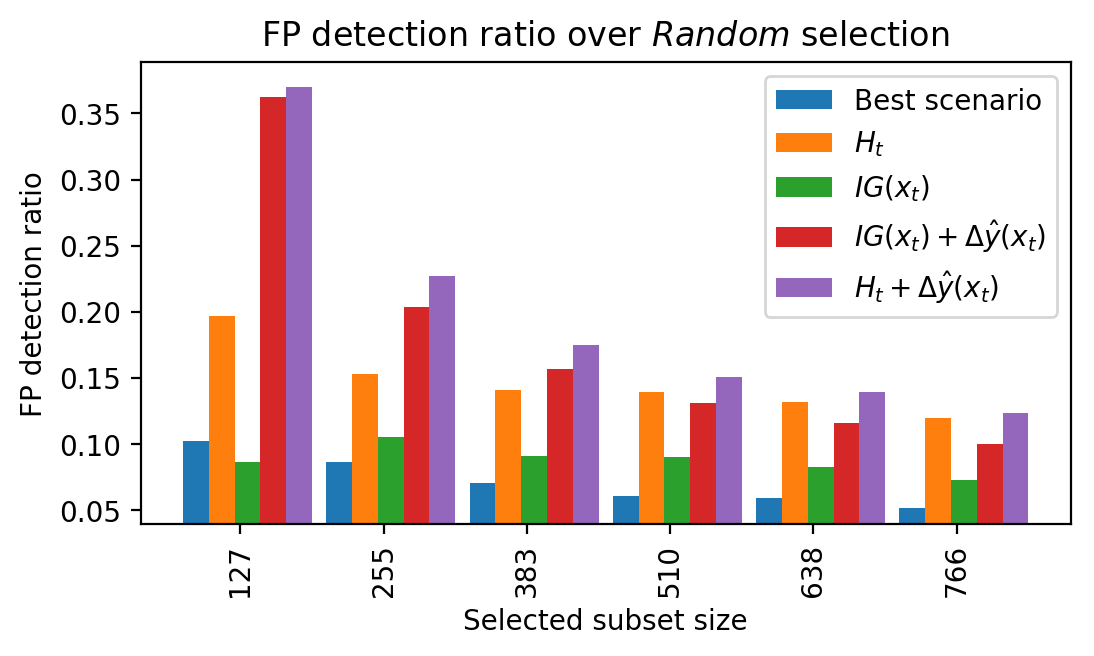

In [14]:
plt.rcdefaults()
fp_plot(probs, strategies_info)

In [15]:
def gt_improvement(probs, sizes, strategy, ratio):
    probs = probs.copy()
    probs = probs.sort_values(strategy, axis=0, ascending=False)
    if ratio:
        ratios = []
        for s in sizes:
            subset = probs.iloc[:s]
            cond = subset['ground_ts_prob']<=subset['ground_mix_prob']
            ratio_s = sum(cond)/s
            ratios.append(ratio_s)
        return np.array(ratios)
    else:
        deltas = []
        for s in sizes:
            subset = probs.iloc[:s]
            delta_s = sum(subset['ground_diff'].values)/s
            deltas.append(delta_s)
        return np.array(deltas)

def gt_random(probs, sizes, ratio):
    if ratio:
        cond = probs['ground_ts_prob']<=probs['ground_mix_prob'] 
        ratio_r = sum(cond)/probs.shape[0]
        return ratio_r
    else:
        delta = sum(probs['ground_diff'].values)/probs.shape[0]
        return delta

def gt_plot(fig, axes, probs, strategies_info, ratio):
    fig.add_subplot(axes)
    ax = plt.gca()
    
    fractions = np.linspace(0, 0.3, 7)[1:]
    sizes = np.copy(fractions)
    sizes *= probs.shape[0]
    sizes = np.array([int(s) for s in sizes])
    n_strategies = len(strategies_info.keys())

    x = np.array(list(range(len(sizes))))
    margin = 0.1
    width = 1 - margin
    width_bar = width/n_strategies

    bars = []
    labels = []
    for i, key in enumerate(strategies_info.keys()):
        offset = margin/2 + (i)*width_bar
        x_i = x + offset
        y_i = gt_improvement(probs, sizes, key, ratio)
        print(key)
        bar = ax.bar(x_i, y_i, width=width_bar, align='edge')
        bars.append(bar)
        label = strategies_info[key]
        labels.append(label)
        
    # Random strategy
    bottom = gt_random(probs, sizes, ratio)
    print(bottom)
    plt.ylim(bottom, None)

    xticks = x + width/2
    xlabels = sizes
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
    
    if ratio:
        plt.title('Objects with increased GTP ratio over $Random$ selection')
        plt.ylabel('Subset increased GTP ratio')
    else:
        ax.legend(bars, labels, loc=1)
        plt.title('GTP average improvement over $Random$ selection')
        plt.ylabel('Subset GTP improvement')
    plt.xlabel('Selected subset size')   

max
baseline
strategy1
strategy2
strategy3
0.026391934220830093
max
baseline
strategy1
strategy2
strategy3
0.6613155833985904


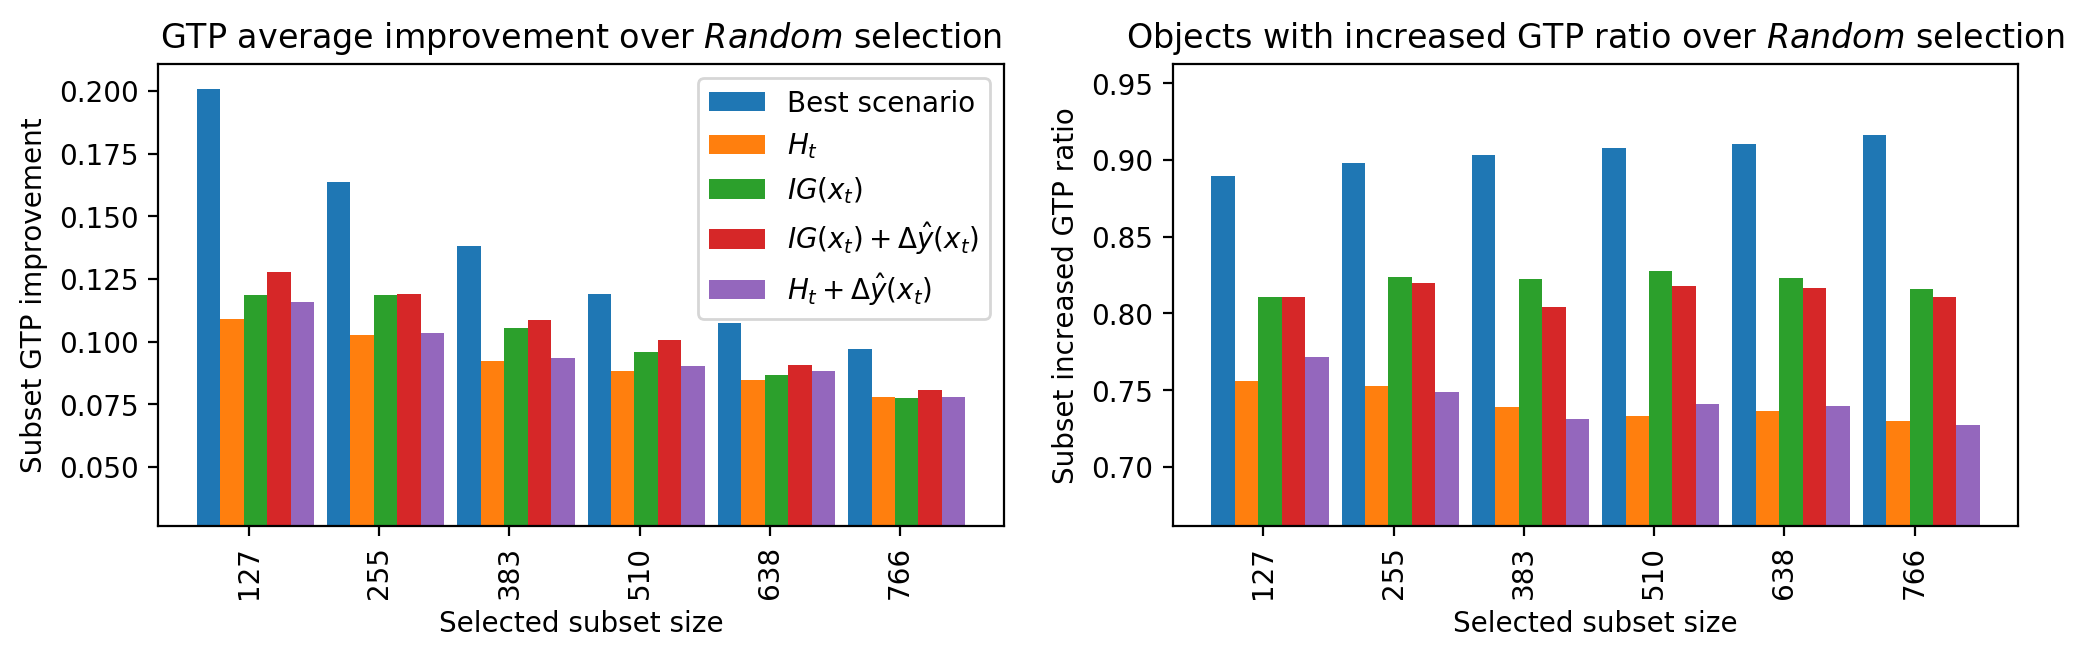

In [16]:
plt.close()
fig = plt.figure(figsize=(12,3), dpi=200)
gt_plot(fig, 121, probs, strategies_info, ratio=False)
gt_plot(fig, 122, probs, strategies_info, ratio=True)
plt.show()

### Strategies comparison: ground-truth, accuracy

In [17]:
def plot_subset_acc(fig, axes, probs, strategies, colors, linestyles, offset=0, kernel_size=1, title=True, xlabel=True,
                    legend=True):
    fig.add_subplot(axes)
    
    index = list(range(1, probs.shape[0]+1))
    probs['ts_right'] = (probs['target']==probs['pred_ts']).astype('int64')
    probs['mix_right'] = (probs['target']==probs['pred_mix']).astype('int64')
    
    for i, key in enumerate(strategies.keys()):
        probs_sort = probs.sort_values(by=key, ascending=False)
        probs_sort['ts_acc'] = probs_sort['ts_right'].cumsum()
        probs_sort['ts_acc'] = probs_sort['ts_acc']/index
        probs_sort['mix_acc'] = probs_sort['mix_right'].cumsum()
        probs_sort['mix_acc'] = probs_sort['mix_acc']/index
        probs_sort['acc_diff'] = probs_sort['mix_acc'] - probs_sort['ts_acc']
        improve = probs_sort['acc_diff'].values
        improve = medfilt(improve, kernel_size)
        
        color = colors[i]
        ls = linestyles[i]
        label = strategies[key]
        plt.plot(index[offset:], improve[offset:], linestyle=ls, label=label, c=color, linewidth=1)
    
    acc_ts = np.sum(probs['ts_right'])/probs.shape[0]
    acc_mix = np.sum(probs['mix_right'])/probs.shape[0]
    random_diff = np.mean(acc_mix-acc_ts)
    plt.hlines(y=random_diff, xmin=0, xmax=probs.shape[0], color=colors[-1], linestyle='dashdot',
               label='Random', linewidth=1)
    if title:
        title = 'Accuracy (%) improvement'
        plt.title(title, fontsize=11)
    if xlabel:
        plt.xlabel('Selected subset size')
    plt.ylabel('Subset accuracy (%) improvement')
    if legend:
        plt.legend(loc=0)

In [18]:
def plot_ground_truth(fig, axes, probs, strategies, colors, linestyles, offset=0, kernel_size=1, title=True, 
                      xlabel=True, legend=True):
    fig.add_subplot(axes)

    index = list(range(1, probs.shape[0]+1))
    for i, key in enumerate(strategies.keys()):
        probs_sort = probs.sort_values(by=key, ascending=False)
        improve = probs_sort['ground_diff'].cumsum().values
        improve = improve/index
        improve = medfilt(improve, kernel_size)
        
        color = colors[i]
        ls = linestyles[i]
        label = strategies[key]
        plt.plot(index[offset:], improve[offset:], linestyle=ls, label=label, c=color, linewidth=1)
    
    random_diff = np.mean(probs['ground_diff'])
    print('GTP mean random: ',random_diff)
    plt.hlines(y=random_diff,xmin=0, xmax=probs.shape[0], color=colors[-1], linestyle='dashdot',
               label='Random', linewidth=1)
    
    if title:
        title = 'GTP average improvement'
        plt.title(title, fontsize=11)
    if xlabel:
        plt.xlabel('Selected subset size')
    plt.ylabel('Subset GTP improvement')
    if legend:
        plt.legend()

In [19]:
def plot_overall_acc(fig, axes, probs, strategies, colors, linestyles, offset=0, kernel_size=1, title=True, 
                     xlabel=True, legend=True):
    fig.add_subplot(axes)
    
    index = list(range(1, probs.shape[0]+1))
    size = probs.shape[0]
    probs['ts_true'] = (probs['target']==probs['pred_ts']).astype('int64')
    probs['mix_true'] = (probs['target']==probs['pred_mix']).astype('int64')
    
    acc_ts = np.sum(probs['ts_right'])/size
    acc_mix = np.sum(probs['mix_right'])/size
    print(acc_mix)
    
    for i, key in enumerate(strategies.keys()):
        probs_sort = probs.sort_values(by=key, ascending=False)
        ts_true = probs_sort['ts_true'][::-1].cumsum()[::-1].values[1:]
        ts_true = np.append(ts_true, [0])
        mix_true = probs_sort['mix_true'].cumsum().values
        acc = (ts_true + mix_true)/size
        acc = medfilt(acc, kernel_size)
        _ = np.where(acc>=acc_mix)[0][0]
        print(key, _)
        
        color = colors[i]
        ls = linestyles[i]
        label = strategies[key]
        plt.plot(index[offset:], acc[offset:], linestyle=ls, label=label, c=color, linewidth=1)
    
    print('random', size*(acc_mix-acc_ts)/(acc_mix-acc_ts))
    x_random = [1, size+1]
    y_random = [acc_ts, acc_mix]
    plt.plot(x_random, y_random, linestyle='dashdot', label='Random', c=colors[-1], linewidth=1)
    
    if title:
        title = 'Overall accuracy (%)'
        plt.title(title, fontsize=11)
    if xlabel:
        plt.xlabel('Selected subset size')
    plt.ylabel('Overall accuracy (%)')
    if legend:
        plt.legend()

In [20]:
def x_percentil(probs, perc=0):
    x_thres_ = (perc*probs.shape[0]/100)//1
    return int(x_thres_)

def add_vline(x, text_y=0.85):
    text = r'$S_{'+str(x)+'}$'
    ax = plt.gca()
    bottom, top = ax.get_ylim()
    ax.axvline(x, 0, 1, linestyle='dotted', color='black')
    ax.text(x-200, text_y*(top-bottom)+bottom, text, rotation=90)
    
def add_hline(y, text_x=0.8):
    text = r'$'+str(y)+'$'
    ax = plt.gca()
    left, right = ax.get_xlim()
    ax.axhline(y, 0, 1, linestyle='dotted', color='black')
    ax.text(text_x*(right-left)+left, y+0.0005, text)

GTP mean random:  0.026391934220830093
0.8719655442443226
max 2505
baseline 794
strategy1 2508
strategy2 2039
strategy3 698
random 2554.0


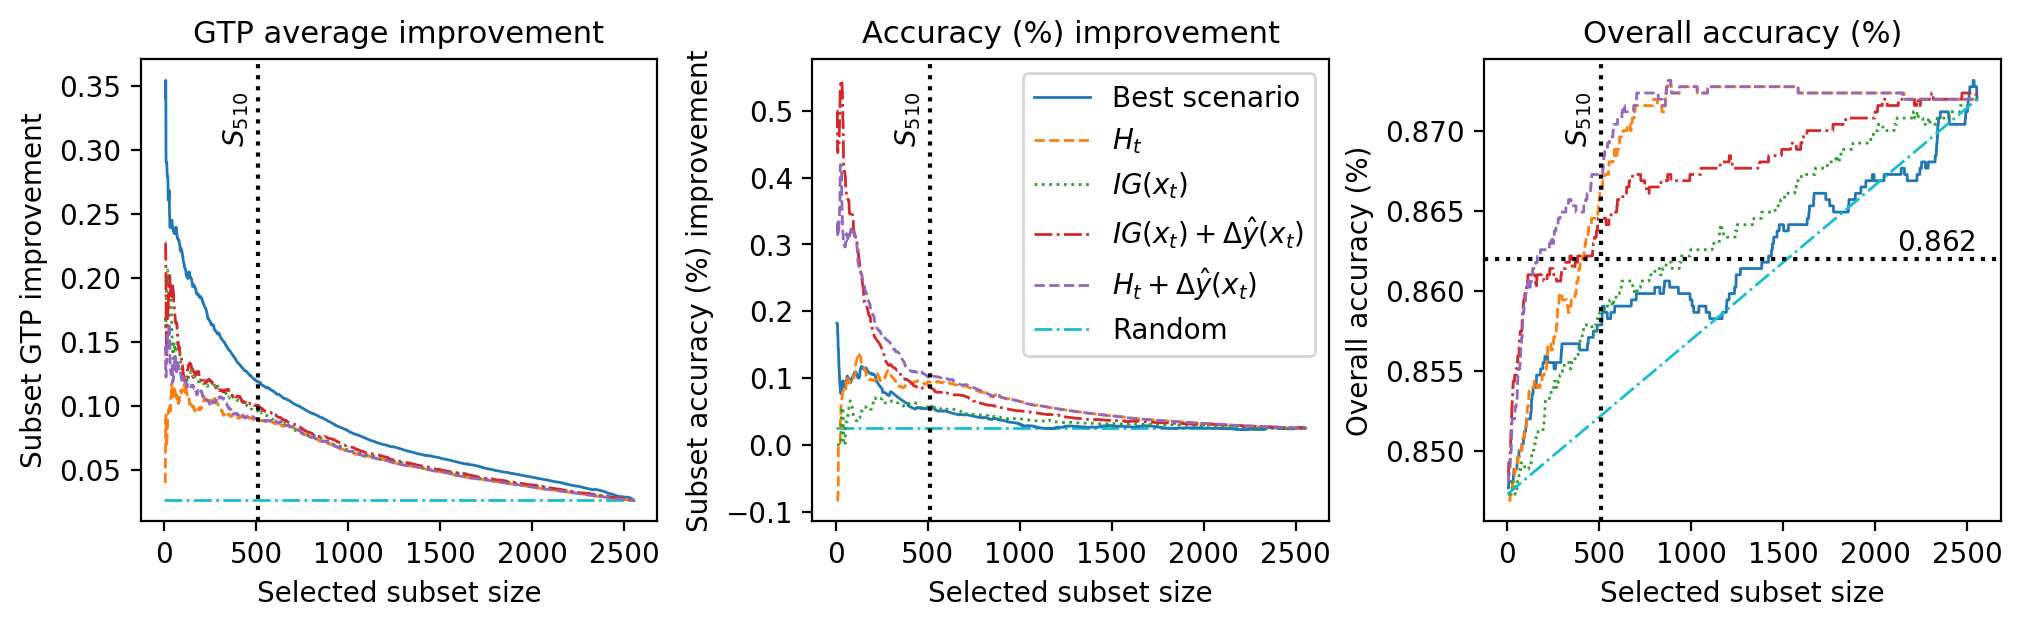

In [21]:
plt.rcParams.update({'font.size': 10})
plt.close()
x_perc_10 = x_percentil(probs, perc=20)

fig = plt.figure(figsize=(12,3), dpi=200)
# fig.suptitle('Configuration 1', y=0.96)
colors = sns.color_palette('tab10')
linestyles = ['-', '--', ':', '-.', 'dashed', 'dashdot', 'dotted']
plot_ground_truth(fig, 131, probs, strategies_info, colors, linestyles, offset=5, kernel_size=3, legend=False)
add_vline(x_perc_10, text_y=0.88)
plot_subset_acc(fig, 132, probs, strategies_info, colors, linestyles, offset=5, kernel_size=13, legend=True)
add_vline(x_perc_10, text_y=0.88)
plot_overall_acc(fig, 133, probs, strategies_info, colors, linestyles, offset=5, kernel_size=11, legend=False)
add_vline(x_perc_10, text_y=0.88)
add_hline(0.862)
ax = plt.gca()
plt.subplots_adjust(wspace=0.3)
plt.show()